# MSDS 534: Statistical Learning - Homework 2

### NAME:  Michael Ryvin

### NET ID:  mar643

### Teammates: David Amiel - dja168, Devyani Mardia - dm1633, Neeti Patel - np912

In this homework, we analyze the [dsprites dataset](https://github.com/google-deepmind/dsprites-dataset) using a variational autoencoder with convolutional layers.

The `dSprites` dataset (Matthey et al. 2017) was created as a benchmark dataset to evaluate the "disentanglement" capabilities of VAEs. That is, how well can VAEs "disentangle" latent factors which generated the data?

`dSprites` is a dataset of 2D shapes procedurally generated from 6 ground truth independent latent factors. These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these latents are present exactly once, generating $737280$ total images.

We will analyze a subset of this data of size $N=60000$.

_Q0: Download `dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz` from Canvas/Files and save in a folder called `data` in the working directory of this notebook._

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [ ]:
n_samples = 60000

In [ ]:
# This is a helper function to load the data
def load_dsprites(n_samples=n_samples, seed=42):
	np.random.seed(seed)

	dataset_zip = np.load('data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

	imgs = dataset_zip['imgs']
	latents_values = dataset_zip['latents_values']
	latents_classes = dataset_zip['latents_classes']

	# subsample data
	ind = np.random.choice(range(imgs.shape[0]), n_samples, replace=False)
	imgs = imgs[ind, :, :]
	latents_values = latents_values[ind, :]
	latents_classes = latents_classes[ind, :]

	# add channel dimension
	imgs = imgs[:, None, :, :]

	# remove first column, it's all zeros
	latents_classes = latents_classes[:, 1:latents_classes.shape[1]]

	return imgs, latents_classes

In [ ]:
images, latents = load_dsprites()

In [ ]:
images.shape

(60000, 1, 64, 64)

In [ ]:
latents.shape

(60000, 5)

_Q1: Complete the following code to get the input and latent dimensions for your VAE. Note that the input dimension should be the height of the image (NOT height * width)._

In [ ]:
input_dim = images.shape[2] # height of image
latent_dim = latents.shape[1]
print(input_dim, latent_dim)

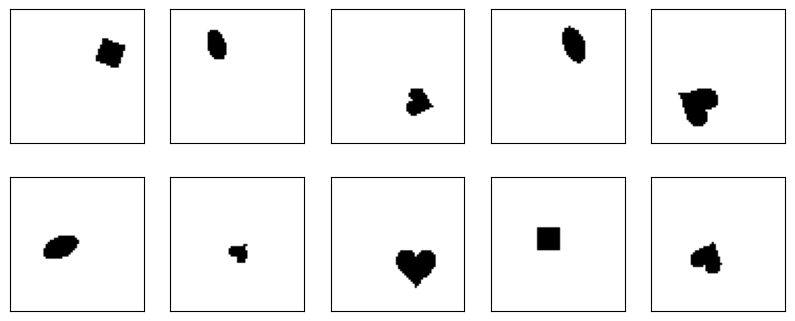

In [ ]:
# plot example figures
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_image = images[i]
    plt.imshow(train_image[0], cmap=plt.cm.binary)
plt.show()

_Q2: Create a `TensorDataset` and a `DataLoader` (with `batch_size=100`) for the data._

In [ ]:
batch_size = 100

torch_images = torch.tensor(images, dtype=torch.float)
torch_latents = torch.tensor(latents, dtype=torch.float)
dataset = TensorDataset(torch_images, torch_latents)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import math

_Q3: Fill in the following code to build a VAE with convolutional layers._

In [ ]:
class ConvVAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, loss_type='mse'):
        super(ConvVAE, self).__init__()
        self.loss_type = loss_type

        kernel_size=4
        stride=2
        padding=1

        channels_encoder = [[1, 32],
                            [32, 16]]

        self.cnn_encode = nn.Sequential(nn.Conv2d(channels_encoder[0][0], channels_encoder[0][1], kernel_size=kernel_size, stride=stride, padding=padding),
                                        nn.ReLU(),
                                        nn.Conv2d(channels_encoder[1][0], channels_encoder[1][1], kernel_size=kernel_size, stride=stride, padding=padding),
                                        nn.ReLU())

        # calculate the height dimension of the output of cnn_encode
        self.out_dim = math.floor((input_dim + 2 * padding - kernel_size)/stride) + 1
        self.out_dim = math.floor((self.out_dim + 2 * padding - kernel_size)/stride) + 1

        # specify the channel dimension of the output of cnn_encode
        out_channel =  channels_encoder[1][1]

        # calculate the dimension of the flattened convolutional output i.e. channel x height x width
        fc_input_dim = out_channel * self.out_dim * self.out_dim
        self.fc_encode = nn.Linear(fc_input_dim, 256)

        self.z_mean = nn.Linear(256, latent_dim)
        self.z_log_var = nn.Linear(256, latent_dim)

        self.fc_decode = nn.Sequential(nn.Linear(latent_dim, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, fc_input_dim),
                                     nn.ReLU())


        self.cnn_decode = nn.Sequential(nn.ConvTranspose2d(channels_encoder[1][1], channels_encoder[1][0], kernel_size=kernel_size, stride=stride, padding=padding),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(channels_encoder[0][1], channels_encoder[0][0], kernel_size=kernel_size, stride=stride, padding=padding))


    def encode(self, x):

        z = self.cnn_encode(x)
        z = z.view(z.size(0), -1)
        z = self.fc_encode(z)
        z_mean = self.z_mean(z)
        z_log_var = self.z_log_var(z)

        return z_mean, z_log_var


    def reparameterize(self, mean, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mean + eps * std

        return sample

    def decode(self, z):

        x = self.fc_decode(z)
        x = x.view(x.size(0), -1, self.out_dim, self.out_dim)
        x = self.cnn_decode(x)

        if self.loss_type == 'binary':
            x_reconstructed = torch.sigmoid(x)

        return x_reconstructed

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean = self.decode(z)

        return x_mean, z, z_mean, z_log_var

    def reconstruction_loss(self, x_pred, x):

        # flatten images
        x_pred = x_pred.reshape(x_pred.shape[0], -1)
        x = x.reshape(x.shape[0], -1)

        if self.loss_type == 'mse':
            loss = nn.MSELoss()
            reconstruction_loss = 0.5 * loss(x_pred, x)

        if self.loss_type == 'binary':
            reconstruction_loss = x * torch.log(x_pred + 1e-6) + (1-x) * torch.log(1-x_pred + 1e-6)
            reconstruction_loss = -reconstruction_loss.sum(1).mean()
        return reconstruction_loss

    def vae_loss(self, x):

        x_mean, z, z_mean, z_log_var = self.forward(x)

        reconstruction_loss = self.reconstruction_loss(x_mean, x)

        kld = 1 + z_log_var - z_mean.pow(2) - z_log_var.exp()
        kl_loss = -0.5 * torch.mean(kld)

        return reconstruction_loss, kl_loss

In [ ]:
# initialize model
model = ConvVAE(input_dim, latent_dim, loss_type='binary')

_Q4: Train the `ConvVAE`. (Note this may take an hour)._

In [28]:
lr = 1e-3
epochs = 40
optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):

    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_idx, (data, _) in enumerate(train_loader):

        reconstruction_loss, kl_loss = model.vae_loss(data)
        total_loss = reconstruction_loss + kl_loss

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += total_loss.item()
        epoch_recon += reconstruction_loss.item()
        epoch_kl += kl_loss.item()

    epoch_loss = epoch_loss / len(train_loader)
    epoch_recon = epoch_recon / len(train_loader)
    epoch_kl = epoch_kl / len(train_loader)

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}", 'recon loss:', f"{epoch_recon:.3}",
              'kld:', f"{epoch_kl:.3}")


epoch:  0 loss: 1.73e+02 recon loss: 1.67e+02 kld: 6.2
epoch:  10 loss: 76.5 recon loss: 72.4 kld: 4.15
epoch:  20 loss: 68.2 recon loss: 63.9 kld: 4.31
epoch:  30 loss: 61.1 recon loss: 56.7 kld: 4.42


_Q5: Fill in the following code to plot reconstructions of the images._

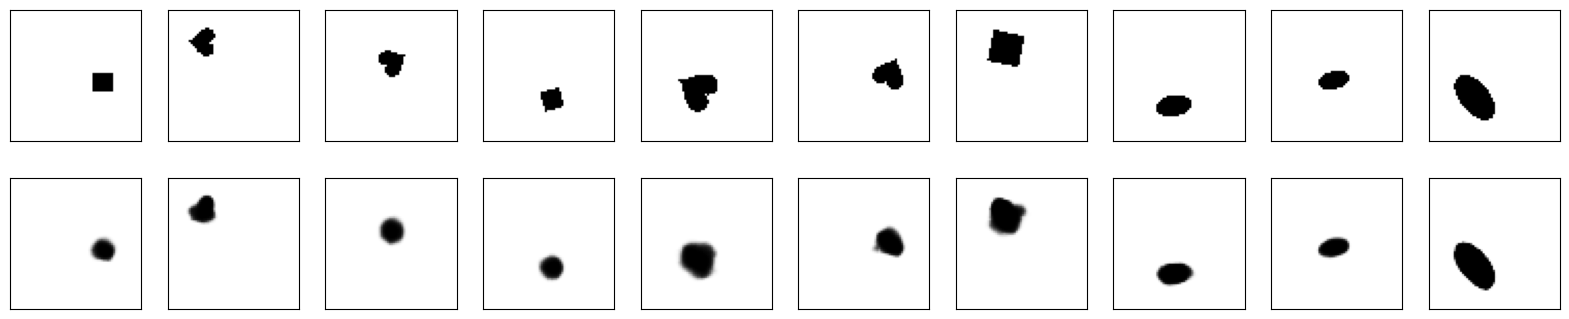

In [29]:
model.eval()

n_img = 10
num_cols = 5
num_rows = 2
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

inds = np.random.choice(range(n_samples), size=n_img)

for i in range(n_img):

  ind = inds[i]

  x = images[ind]
  x = x[None, :, :, :] # add N dimension

  x = torch.tensor(x, dtype=torch.float)

  # get reconstruction of image x from ConvVAE
  x_recon, _, _, _ = model.forward(x)


  plt.subplot(num_rows, 2 * num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[0][0].detach().cpu().numpy(), cmap=plt.cm.binary)

  plt.subplot(num_rows, 2 * num_cols, (i + 1) + 2 * num_cols)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_recon.detach().cpu().numpy()[0][0], cmap=plt.cm.binary)


_Q6: Create latent traversal plots to visualize how changing the first 2 dimensions of the latent space affects the output images._

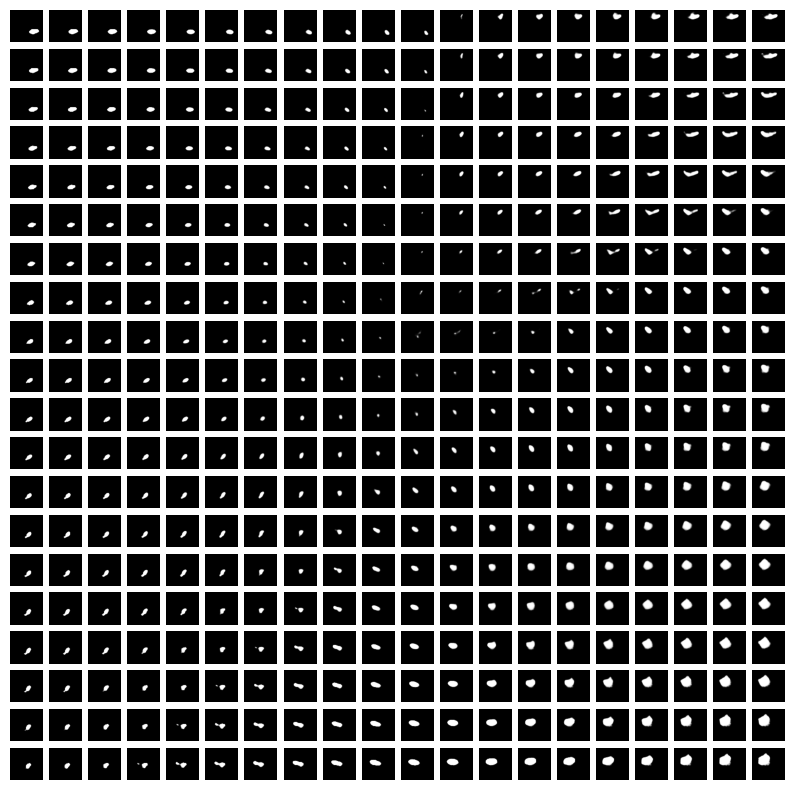

In [30]:
# Create a grid of latent vectors for traversal
n_samples = 20
grid_x = np.linspace(-3, 3, n_samples)
grid_y = np.linspace(-3, 3, n_samples)
traversal_grid = torch.FloatTensor(n_samples, n_samples, latent_dim)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = torch.FloatTensor([xi, yi] + [0] * (latent_dim - 2))

        traversal_grid[j, i] = z_sample

# Generate images from the latent traversal grid
with torch.no_grad():
    traversal_grid = traversal_grid.view(-1, latent_dim)
    generated_images = model.decode(traversal_grid)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    for j in range(n_samples):
        plt.subplot(n_samples, n_samples, i * n_samples + j + 1)
        plt.imshow(generated_images[i * n_samples + j].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

plt.show()
